# Master Causal Inference with the Power of Front Door Adjustment: The Only Complete Guide Online

## A fully working example of the front door adjustment formula using Python and the pgmpy library including a step-by-step explanation of the calculations

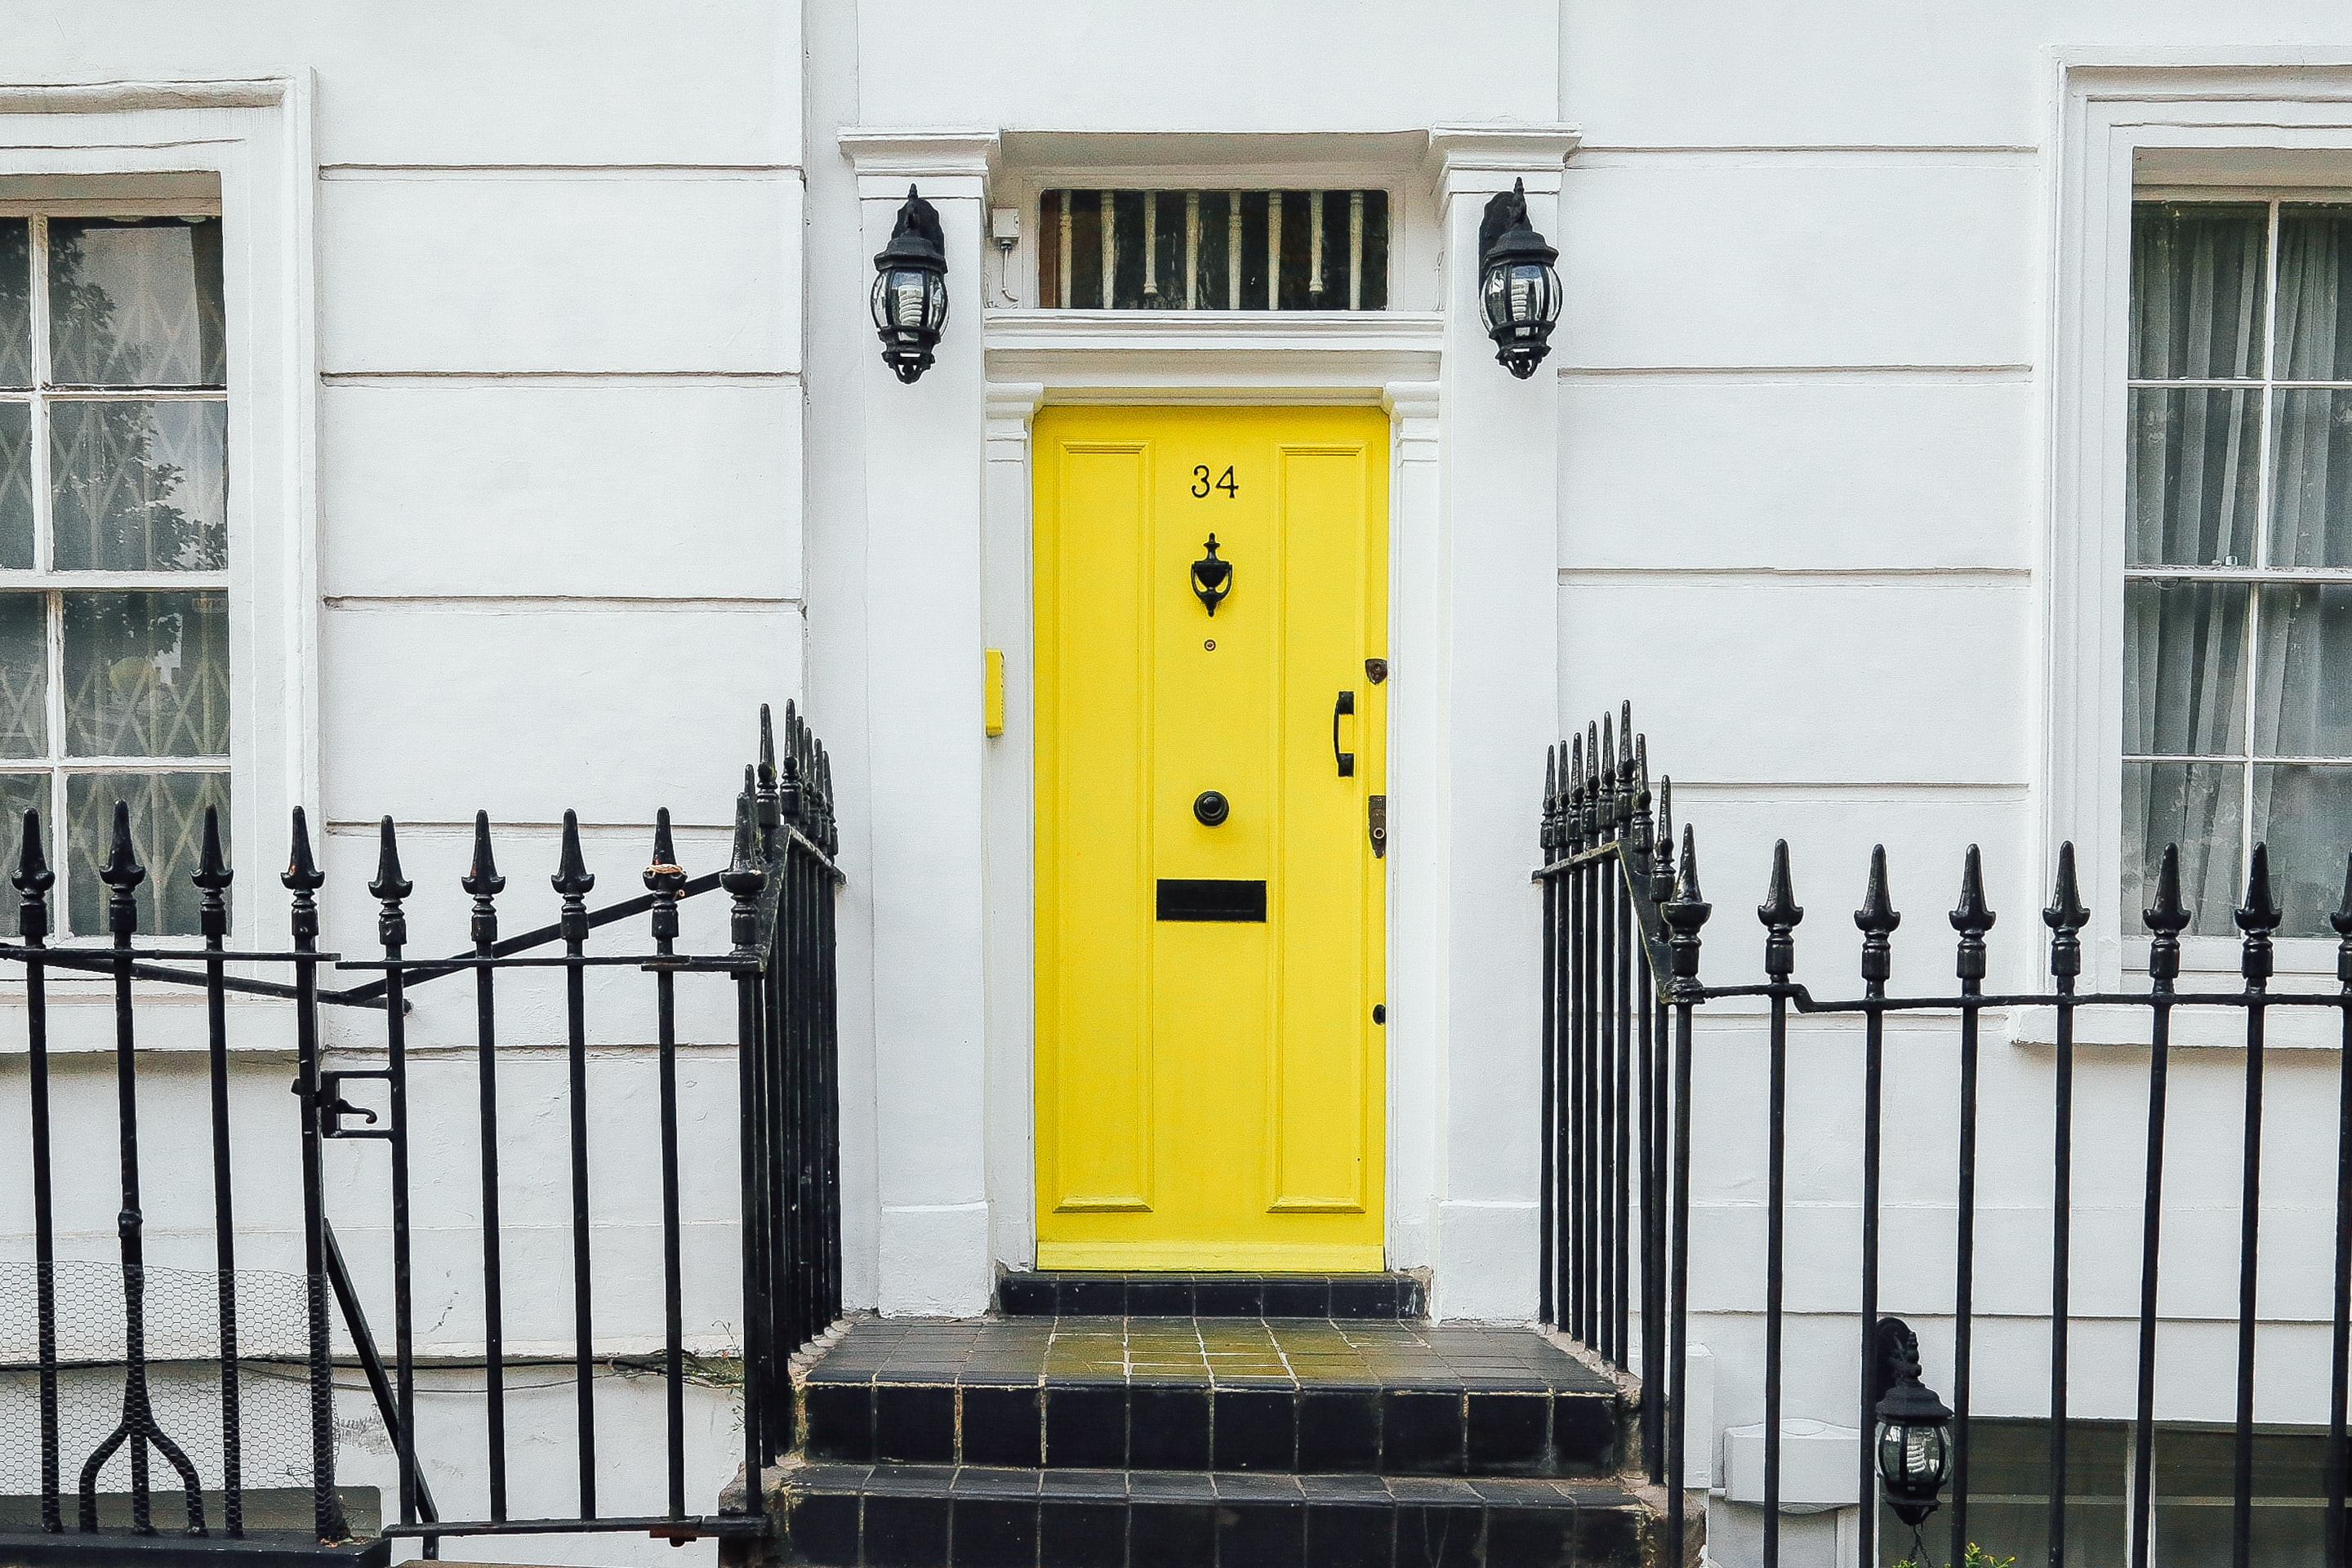
Photo by <a href="https://unsplash.com/@evelynparis?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Evelyn  Paris</a> on <a href="https://unsplash.com/s/photos/front-door?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

## Objective
By the end of this article you will understand the magic of the "front door adjustment" formula that can calculate the effect of an event on an outcome, even where there are other factors affecting both that are not measured or even known about with all the Python code and a full explanation.

I have scoured the Internet and many books trying to find a fully working example of the front door formula and have drawn a blank, so unless this is an article out there that I have missed, what you are about to read is genuinely unique ...

## Introduction

In a recent article I explored the power of the backdoor adjustment formula to calculate the true effect of an event on an outcome even if there are factors that are "confounding" both. 

https://towardsdatascience.com/unlock-the-power-of-causal-inference-a-data-scientists-guide-to-understanding-backdoor-686d2826efa4

What we wanted to know was the true effect of taking a drug on patient recovery rates and the magic of the backdoor adjustment formula recovered this effect even though "male" was obscurring that result because -

- A higher proportion of males took the drug compared to females
- Males had a higher recovery rate than females

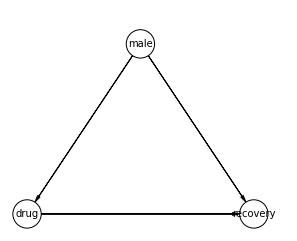

In [1]:
from dag_tools import DirectedAcyclicGraph

edges : list = [("male", "drug"), ("male", "recovery"), ("drug", "recovery")]
pos : dict = {"drug": [1, 1], "male": [3, 4], "recovery": [5, 1]}    
    
dag = DirectedAcyclicGraph(edges=edges)
dag.display_pgm_model(pos=pos)

In this example "male" is a "confounder" but the values for "male" were included in the observation data and then the back door formula was applied to prove that the drud trial was having a positive impact.

But what if the "confounder" could not be measured and was not included in the data.

During the 1950's there was a statistical war raging between scientists who strongly believed that smoking caused lung cancer and the tobacco companies who managed to produce "evidence" to the contrary. 

The essence of this evidence was the proposal that a genetic factor was responsible for both smokers taking up smoking and there likelihood of developing cancer. This was a convenient hypothesis because it was nearly impossible to test.

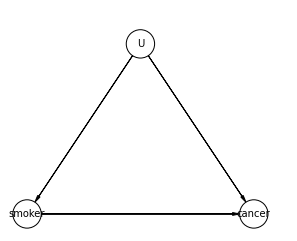

In [2]:
edges : list = [("U", "smoker"), ("U", "cancer"), ("smoker", "cancer")]
pos : dict = {"smoker": [1, 1], "U": [3, 4], "cancer": [5, 1]}    
    
dag = DirectedAcyclicGraph(edges=edges)
dag.display_pgm_model(pos=pos)

If this is the only data you have i.e. a simple backdoor path from an unobserved confounder to both an event and an outcome then there is nothing that can be done; the true effect cannot be recovered.

However, there are two other "patterns" where the effect can be recovered, the front-door criteria and instrumental variables. This article will fully explain the first of those patterns.

To satisfy the front-door criteria there needs to be an intermediary between the event and the outcome, and in the smoking example it looks like this -

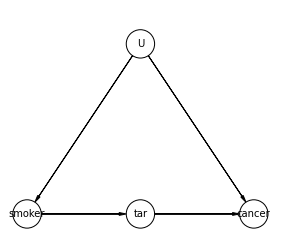

In [3]:
edges : list = [("smoker", "tar"), ("tar", "cancer"), ("U", "smoker"), ("U", "cancer")]
pos : dict = {"smoker": [1, 1], "tar": [3, 1], "cancer": [5, 1], "U": [3,4]}    
    
dag = DirectedAcyclicGraph(edges=edges)
dag.display_pgm_model(pos=pos)

When this pattern exists, the effect of the event (smoking) on the outcome (cancer) can genuinely be isolated and recovered irrespective of the influence of an unobserved confounder using the "Front-Door Adjustment Formula" as proposed by Judea Pearl in "The Book of Why" and "Causal Inference in Statistics".

It seems like magic and the implications genuinely are magic but if you follow the steps in the rest of this article you will be able to add this amazing technique to your data science tool bag with just a few lines of Python code!

- The Book of Why: https://amzn.to/3iCVF8r
- Causal Inference in Statistics: https://amzn.to/3WblFp1

## Getting Started
The first thing we need are some test data. I have created a synthetic dataset using my ``BinaryDataGenerator`` class (if you would like the full source code, head over to this article - 
- https://towardsdatascience.com/how-to-generate-synthetic-data-for-any-causal-inference-project-in-less-than-10-lines-of-code-158688a89349).

In [1]:
import sys
sys.path.insert(1, r'C:\Users\GHarrison\OneDrive - Lincoln College\Python Projects\Data Science\Utilities')

from Causal.lib.synthetic_utils import BinaryDataGenerator

import pandas as pd

generator = BinaryDataGenerator(population_size=800, columns=["smoker", "tar", "cancer"], random_state=42)
generator.set_values(col_name="smoker", frac=0.5)
generator.set_values(col_name="tar", frac=0.05, condition=generator.data["smoker"]==0)
generator.set_values(col_name="tar", frac=0.95, condition=generator.data["smoker"]==1)
generator.set_values(col_name="cancer", frac=0.15, condition=((generator.data["smoker"]==1) & (generator.data["tar"]==1)))
generator.set_values(col_name="cancer", frac=0.1, condition=((generator.data["smoker"]==1) & (generator.data["tar"]==0)))
generator.set_values(col_name="cancer", frac=0.95, condition=((generator.data["smoker"]==0) & (generator.data["tar"]==1)))
generator.set_values(col_name="cancer", frac=0.9, condition=((generator.data["smoker"]==0) & (generator.data["tar"]==0)))
df_smoking = generator.data

df_summary = df_smoking.groupby(["cancer"]).value_counts().reset_index().iloc[:, [1, 2, 0, 3]]
df_summary.rename(columns={0: "count"}, inplace=True)
df_summary

,smoker,tar,cancer,count
0,1,1,0,323
1,0,0,0,38
2,1,0,0,18
3,0,1,0,1
4,0,0,1,342
5,1,1,1,57
6,0,1,1,19
7,1,0,1,2


In [2]:
df_smoking

,smoker,tar,cancer
0,1,1,1
1,0,0,1
2,1,1,0
3,1,1,0
4,0,0,1
...,...,...,...
795,1,1,0
796,1,1,0
797,0,0,1
798,1,0,0


A summary analysis of the data is as follows -

- There were 800 people in the sample. 
- 50% of the sample population were smokers (400/800)
- Of the smokers, 95% had tar deposits (380/400)
- Of the non-smokers, 5% had tar present (20/400)
- Of the smokers who had tar present, 15% had cancer (47/380)
- Of the smokers who had no tar, 10% had cancer (2/20)
- Of the non-smokers who had tar present, 95% had cancer (19/20)
- Of the non-smokers who had no tar present, 90% had cancer (342/380)

## First Attempt : Using the Pgmpy Library
In the backdoor article I started by showing a simple solution using ``pgmpy`` so this feels like a good place to start ...

The expected result is 4.5% (more on this later) but ``pgmpy`` crashes with ``ValueError: Maximum Likelihood Estimator works only for models with all observed variables. Found latent variables: set().``.

After a lot of research and also raising an issue with the development team the conclusion is that ``pgmpy`` does not work when applying the "do" operator (i.e. making an intervention) where there is an unobserved confounder and that it cannot apply the front-door adjustment formula.

It is worse than that though as the ``DoWhy`` library does not work in this instance either.

``DoWhy`` can deal with unobserved confounders when calculating the "Average Treatment Effect" (ATE) but when the "do" operator is being applied to simulate an intervention it fails in the same way as ``pgmpy``. 

ATE is applied to continuous varaibles, so we can ask ``DoWhy`` a question like "If carbon-dioxide emmssions increase by 100 million tonnes what is the causal effect on the increase global temperatures" and ``DoWhy`` will produce a result. 

However, when applying a "do" intervention to discrete, binary data, for example "What is the probability of cancer given that everyone in the sample smokes?" neither ``pgmpy`` or ``DoWhy`` can perform the calculation where an unobserved confounder is present and to date I have not found any other libraries that can.

My backdoor article moved on from the ``pgmpy`` implementation to provide an example of the maths to show what ``pgmpy`` was doing behind the scenes. In this article an understanding of the maths is required so that we can build our own implementation of the front-door adjustment formula in Python ...

## Second Attempt: Working it Out by Hand

The objective is to calculate the Average Causal Effect (ACE) by simulating the following -

1. Travel back in time and perform and intervention which forces everyone to smoke.
2. Perform the same time-travelling trick again and this time force everyone to quit.
3. Subtract the second result from the first.

Expressed mathematically using the "do" operator this amazing feat looks like this -

$$
①\ \textbf{ACE} = P(Y=1 \mid do(X=1)) - P(Y=1 \mid do(X=0))
$$

And as we know that there is an unobserved confounder and a front-door path in the data so we need to substitute each side of the ACE formula with the front door adjustment formula as proposed by Judea Pearl -

$$
②\ P(y \mid do(x)) = \sum_{z} P(z\mid x) \sum_{x'}P(y\mid x',z)P(x')
$$

Let's start with the left hand side of the ACE formula, substitute it for the front-door adjustment formula and use the variables that are present in our data instead of x, y and z. To keep things neat and tidy the following abbreviations will be used: S = Smoker, C = Cancer, T = Tar ...

$$
③\ P(C=1 \mid do(S=1)) = \\\sum_{t} P(T=t\mid S=1) \times \left[\sum_{s}P(C=1\mid S=s,T=t) \times P(S=s)\right]$$

t can take values {0, 1} and s can take values {0, 1} so we now need to expand as follows ...

$$
④\ P(C=1 \mid do(S=1)) = 
\\P(T=0\mid S=1) \times \left[\sum_{s}P(C=1\mid S=s,T=0) \times P(S=s)\right]
\\+
\\P(T=1\mid S=1) \times \left[\sum_{s}P(C=1\mid S=s,Tar=1) \times P(S=s)\right]
$$

... and the inner $\sum_{s}$ terms can be further expanded as follows -
$$
⑤\ P(C=1 \mid do(S=1)) = 
\\P(T=0\mid S=1) \times \\\left[(P(C=1\mid S=0,T=0) \times P(S=0)) + (P(C=1\mid S=1,T=0) \times P(S=1))\right]
\\+
\\P(T=1\mid S=1) \times \\\left[(P(C=1\mid S=0,T=1) \times P(S=0)) + (P(C=1\mid S=1,T=1) \times P(S=1))\right]
$$

Now it should be a simple matter of substituting the conditional probabilities from the data. A Python function will be provided to calculate any conditional probability from data in the next section, but for now here are the values that are needed -

$$
P(T=0 \mid S=1) = 0.05
\\P(C=1 \mid S=0, T=0) = 0.9
\\P(S=0) = 0.5
\\P(C=1 \mid S=1, T=0) = 0.1
\\P(S=1) = 0.5
\\P(T=1 \mid S=1) = 0.95
\\P(C=1 \mid S=0, T=1) = 0.95
\\P(S=0) = 0.5
\\P(C=1 \mid S=1, T=1) = 0.15
\\P(S=1) = 0.5
$$

Substituting these conditional probabilities gives ...

$$
⑥\ P(C=1 \mid do(S=1)) = 0.05 \times \left[(0.9 \times 0.5) + (0.1 \times 0.5)\right]
+
0.95 \times \left[(0.95 \times 0.5) + (0.15 \times 0.5)\right]
\\= 0.05 \times \left[(0.45) + (0.05)\right] + 0.95 \times \left[(0.475) + (0.075)\right]
=0.05×0.5+0.95×0.55
\\=0.025 + 0.5225
\\=0.5475
$$

So ...
$$
⑦\ P(C=1 \mid do(S=1)) = 0.5475
$$

... and if you re-calculate all of the steps above again for $P(C=1 \mid do(S=0))$ the answer is ...

$$
⑧\ P(C=1 \mid do(S=0)) = 0.5025
$$
And so the overall Average Causal Effect is ...

$$
⑨\ \textbf{ACE} = p(C=1 \mid do(S=1)) - p(C=1 \mid do(S=0))
\\ = 0.5475 - 0.5025
\\ = 0.045
$$

That was a lot of effort to work out the Average Causal Effect by hand! Fortunately, now that the workings of the front-door adjustment formula are fully understood it is relatively easy to convert all of this to Python so that the whole thing can be fully automated for any dataset where the features are discrete values ...

## Third Attempt: A Reusable Python Function

The first step is to provide an easy-to-use function that can calculate conditional probabilities for any dataset (do not worry too much about fully understanding this code as the focus of the article is on understanding front-door adjustment in the next code block) ...

In [5]:
from typing import Tuple
from IPython.display import Math, display

import re
import ast

def __int_float_str(v : any) -> any:
    try:
        return ast.literal_eval(v)
    except ValueError:
        return v

def __extract_outcome_events(cond_prob: str) -> Tuple[tuple, dict]:
    cond_prob = cond_prob.replace(" ", "")
    outcome = re.findall(r'(?i)[p]\((\w+)=(\d+)', cond_prob)[0]
    events = {k:__int_float_str(v) for k,v in re.findall(r'(\w+)=(\w+)', re.search(r'(?i)[p]\(([^|]+)\|?(.*)', cond_prob).group(2))}

    return (outcome[0], __int_float_str(outcome[1])), events

def calc_cond_prob(df_data: pd.DataFrame, cond_prob : str = None, outcome : tuple = None, events : dict = {}, display_latex : bool = False) -> float:
    """Calculates a conditional probability from the values in a DataFrame

    Args:
        df_data (pd.DataFrame): The DataFrame being used
        cond_prob (str): The conditional probaility being calculated, for example p(A=1|B=1)
        outcome (tuple, optional): If cond_prob is not passed the outcome can be specified directly. Defaults to None.
        events (dict, optional): If cond_prob is not passed the events can be specified directly. Defaults to None.
        display_latex (bool, optional): If True the a Latex representation of the conditional probability is displayed. Defaults to False.

    Returns:
        float: The calculated conditional probability
    """
    if outcome is None and len(events) == 0:
        outcome, events = __extract_outcome_events(cond_prob)

    for feature, value in events.items():
        df_data = df_data[df_data[feature] == value]

    prob = df_data[df_data[outcome[0]]==outcome[1]].shape[0] / df_data.shape[0]

    if display_latex:
        mid_char : str = r"\mid"
        display(Math(f"p({outcome[0]}={outcome[1]} {'' if len(events) == 0 else mid_char} {', '.join('{}={}'.format(k,v) for k,v in events.items())}) = {prob}"))

    return prob

So ``calc_cond_prob`` can be used to easily calculate conditional probabilities from any ``DataFrame`` as follows ...

In [6]:
p_nocancer_given_non_smoker_no_tar = calc_cond_prob(df_data=df_smoking, cond_prob="p(cancer=0|smoker=0,tar=0)", display_latex=True)

<IPython.core.display.Math object>

... or alternatively the ``outcome`` and ``events`` can be specified explicitly as follows ...

In [7]:
p_nocancer_given_non_smoker_no_tar = calc_cond_prob(df_data=df_smoking, outcome=("cancer", 0), events={"smoker": 0, "tar": 0}, display_latex=True)

<IPython.core.display.Math object>

Given the lessons learnt from performing the calculation by hand and a really neat function to calculate conditional probabilities from any ``DataFrame`` a Python function for the front-door adjustment formula can be developed as follows -

In [8]:
def front_door_adjustment(df_data : pd.DataFrame, x_col : str, y_col : str, z_col : str, y_val : any, x_val : any, verbose : bool = False) -> float:

    p_y_given_do_x = 0

    for z in sorted(df_data[z_col].unique()):
        
        p_z_given_x = calc_cond_prob(df_data=df_data, outcome=(z_col, z), events={x_col: x_val}, display_latex=verbose)
        
        sigma_x_dash = 0
        for x_dash in sorted(df_data[x_col].unique()):
            
            p_y_given_x_dash_z = calc_cond_prob(df_data=df_data, outcome=(y_col, y_val), events={x_col: x_dash, z_col: z}, display_latex=verbose)
            p_x_dash = calc_cond_prob(df_data=df_data, outcome=(x_col, x_dash), display_latex=verbose)
            
            sigma_x_dash += (p_y_given_x_dash_z * p_x_dash)
                        
        p_y_given_do_x += (p_z_given_x * sigma_x_dash)
        
    mid_char : str = r"\mid"
    display(Math(f"p({y_col}={y_val} {mid_char} do({x_col}={x_val}))={p_y_given_do_x}"))
    
    return p_y_given_do_x

... and can be called as like this ...

In [9]:
p_cancer_1_do_smoker_1 = front_door_adjustment(df_data=df_smoking, x_col="smoker", y_col="cancer", z_col="tar", y_val=1, x_val=1)
p_cancer_1_do_smoker_0 = front_door_adjustment(df_data=df_smoking, x_col="smoker", y_col="cancer", z_col="tar", y_val=1, x_val=0)

print(f"The average causal effect (ACE) of smoking on cancer is {p_cancer_1_do_smoker_1 - p_cancer_1_do_smoker_0:+.1%}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The average causal effect (ACE) of smoking on cancer is +4.5%


## Conclusion
To start with the elephant in the room, if the effect of smoking was an increase in the average probability of developing cancer of just 4.5% this would not persuade many smokers to quit.

However we saw that the individual probability of cancer given smoker $p(Cancer = 1\mid do(Smoker=1)) = 54.75\%$. The reason the ACE is so low is that our fictitious tobacco companies pulled the dastardly trick of stacking the deck by ensuring that lots of non-smokers with cancer made it into the sample in an attempt to obfuscate the truth i.e. that smoking causes cancer.

But even with this noise in the data, and even if we accept the unlikely hypothesis that an unmeasurable genetic factor exists that confounds both the event and the outcome, the magic of the front-door adjustment formula has still uncovered a positive causal link between smoking and cancer!

This amazing outcome is unlike anything I have discovered in other data science techniques and it plays into the most common questions that customers of my machine learning predictions always ask, i.e. -

- Yes, but that why does that happen?
- And what should I do to change the outcome and improve things?

These types of "why?" questions make the knowledge, ability and understanding required to apply front-door adjustment in order to calculate the effect of "interventions" absolutely invaluable.

Unfortunately the currently avaialable libraries including ``pgmpy`` and ``DoWhy`` do not work when applying the "do" operator to discrete data sets that include an unobserved confounder and a front door path. 

That is a massive gap in the functionality of those libaries and having searched at length to find a Python solution with a worked example both online and in books I have not managed to find one.

Unless I have over-looked some examples that makes this article unique and I wish I had been able to read it when front-door adjustment began to fascinate me rather than having to do all that research myself. 

It was a lot of fun though and I really hope you like the result!

## Bonus Section
So having said that ``pgmpy`` does not work in this scenario and having come so far in my learning journey I decided to write a version of the front-door adjustment formula in Python to correct that omission.

Just to note I decided to re-factor the formula to make the Python implementation a bit more concise changing this ...

$$
P(y \mid do(x)) = \sum_{z} P(z\mid x) \sum_{x'}P(y\mid x',z)P(x')
$$

into this ...

$$
P(y \mid do(x)) = \sum_{z} \sum_{x'} P(y \mid z, x') P(x') P(z \mid x)
$$

... which is mathematically equivalent and is just like saying 4 x 3 x 1 x 2 x 2 = 4 x 1x 2 x 2 x 3

The first step is to create the causal model using ``pgmpy``  classes. To note: the unobserved confounder must be removed from the ``edges`` list as this is what causes the ``.fit()`` method to crash with a ``ValueError`` ...

In [10]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import CausalInference

edges : list = [("smoker", "tar"), ("tar", "cancer"), ("U", "smoker"), ("U", "cancer")]
df_data = df_smoking

causal_model = BayesianNetwork(edges)
causal_model.remove_node("U") # The unobserved confounder must be forceably removed or the fit() method will crash with the ValueError

causal_model.fit(df_data)
causal_model.check_model()

True

Once the set-up is complete, the front-door formula can be implemented in Python as follows ...

In [11]:
import copy

def pgmpy_front_door_formula(causal_model : BayesianNetwork, df_data : pd.DataFrame, x_col : str, y_col : str, z_col : str, y_val : any, x_val : any, verbose : bool = False) -> float: 

    # This is a critical adjustment. Because the relationships are x -> z -> y pgmpy will create a conditional
    # probability table for y that is based solely on z. 
    # However, the front-door formula needs to be able to calculate p(y | x, z) hence a temporary edge needs 
    # to be added to the model between x and y so that x and z both appear in the internal CPT representing y ...
    causal_model = copy.deepcopy(causal_model) # Take a copy so the original is not modified
    causal_model.add_edge(x_col, y_col) # Add the temporary edge between x and y
    causal_model.fit(df_data) # Re-fit to include the new relationship
    
    if verbose == True:
        for cpt in causal_model.get_cpds():
            print(cpt)    
            
    p_y_given_do_x = 0

    for z in sorted(df_data[z_col].unique()):
        p_z_given_x = causal_model.get_cpds(z_col).get_value(**{z_col: z, x_col: x_val})
        
        for x_dash in sorted(df_data[x_col].unique()):
            p_y_given_z_x_dash = causal_model.get_cpds(y_col).get_value(**{y_col: y_val, z_col: z, x_col: x_dash})
            p_x_dash = causal_model.get_cpds(x_col).get_value(**{x_col: x_dash})

            p_y_given_do_x += p_y_given_z_x_dash * p_x_dash * p_z_given_x
        
    mid_char : str = r"\mid"
    display(Math(f"p({y_col}={y_val} {mid_char} do({x_col}={x_val}))={p_y_given_do_x}"))

    return p_y_given_do_x

And just to prove that it works, the calculation produces exactly the same results as both the manual calculation and the earlier Python function that works directly on the ``DataFrame`` ...

In [12]:
p_cancer_1_do_smoker_1 = pgmpy_front_door_formula(causal_model=causal_model, df_data=df_smoking, x_col="smoker", y_col="cancer", z_col="tar", y_val=1, x_val=1)
p_cancer_1_do_smoker_0 = pgmpy_front_door_formula(causal_model=causal_model, df_data=df_smoking, x_col="smoker", y_col="cancer", z_col="tar", y_val=1, x_val=0)

print(f"The average causal effect (ACE) of smoking on cancer is {p_cancer_1_do_smoker_1 - p_cancer_1_do_smoker_0:+.1%}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The average causal effect (ACE) of smoking on cancer is +4.5%


## References
If you would like to know more about the ``pgmpy`` library the full documentation can be found here: https://pgmpy.org/index.html.

And the ``DoWhy`` documentation can be found here: https://www.pywhy.org/dowhy/v0.9.1/

If you would like to know more about causal inference, this amazing book is a great place to get started: https://amzn.to/3iCVF8r

And this book provides a deeper and more detailed exploration of some of the key concepts: https://amzn.to/3WblFp1

# TODO: 
- The LaTeX output should be added to the front-door functions :-( !!!!
- Put it in a library
- Take a back-up!